In [96]:
import pennylane as qml
import numpy as np
from qutip import Bloch
# 定义量子设备，支持状态向量模拟
dev = qml.device("lightning.gpu", wires=4)




In [97]:
n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 16              # Number of samples for each training step
num_epochs = 1             # Number of training epochs
num_experiences = 10        # Number of experiences
num_classes = 200            # Number of classes in the dataset
train_mb_size= 256            # Number of samples for each training step
eval_mb_size=100            # Number of samples for each evaluation step
memory_size = 2000          # Number of total samples in the memory
q_depth = 4                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
alpha=0.5                   # the weight of the old model in the loss function
temperature=2.0             # temperature for the distillation loss

In [98]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)

def RX_layer(w):
    """Layer of parametrized qubit rotations around the x axis.
    """
    for idx, element in enumerate(w):
        qml.RX(element, wires=idx)

def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def phase_layer(w):
    """Layer of S gates and T gates to flip the phase of the qubits.
    """
    for idx in range(w):
        if idx % 2 == 0:
            qml.S(wires=idx)
        else:
            qml.T(wires=idx)
            
def entangling_layer_3(nqubits):
    """Layer of controlled-Rz gates followed by zz entangling gates. 
    """
    params = np.random.uniform(0, 2*np.pi, (nqubits,))
    for i in range(0, nqubits - 1, 2):
        qml.ctrl(qml.RZ, control=i)(params[i], wires=i + 1)
    for i in range(1, nqubits - 1, 2):
        qml.IsingZZ(params[i],wires=[i, i + 1])

def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [99]:
@qml.qnode(dev)
def quantum_state(q_input_features, q_weights_flat):
    """
    计算量子态。
    """
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)
    
    H_layer(n_qubits)  # 施加 Hadamard 门
    RX_layer(q_input_features)  # 施加 RX 旋转门
    
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    return qml.state()  # 只返回量子态

In [100]:
state = quantum_state(np.random.random(n_qubits), np.random.random(q_depth * n_qubits))
print("量子态: ", state)
print(type(state))

量子态:  [-0.06708591+0.10515057j -0.04555723+0.07140649j -0.05709771+0.08949506j
 -0.00954576+0.01496205j  0.10205793-0.15996579j  0.08105056-0.12703879j
  0.13295715-0.20839728j  0.1024718 -0.16061449j  0.11894484-0.18643437j
  0.19486931-0.30543851j  0.23243625-0.36432101j  0.25813157-0.4045959j
  0.10426888-0.16343123j  0.1692394 -0.26526615j -0.14548005+0.2280257j
  0.02720291-0.04263789j]
<class 'numpy.ndarray'>


Bloch 球坐标:  [0.021129362726387914, -3.469446951953614e-18, 0.008382814293987545]


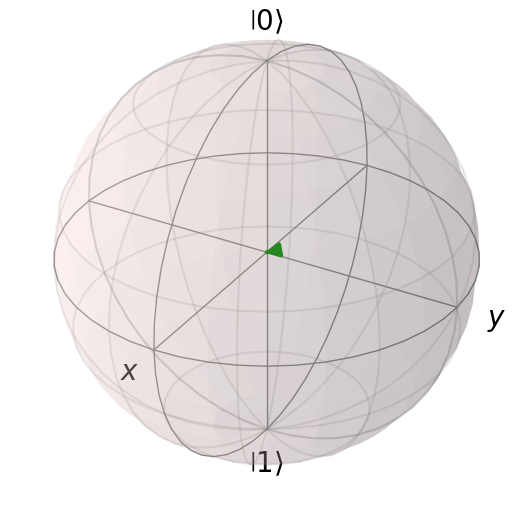

In [101]:
# 计算 Bloch 球坐标
bloch_vector = [2 * np.real(state[0] * np.conj(state[1])),
                2 * np.imag(state[0] * np.conj(state[1])),
                np.real(state[0] * np.conj(state[0]) - state[1] * np.conj(state[1]))]

print("Bloch 球坐标: ", bloch_vector)

# 绘制 Bloch 球
b = Bloch()
b.add_vectors(bloch_vector)  # 添加量子态的 Bloch 坐标
b.show()

In [102]:
@qml.qnode(dev)
def quantum_net_3(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)


    # Sequence of trainable variational layers
    for _ in range(q_depth):
        RX_layer(n_qubits)
        phase_layer(n_qubits)
        entangling_layer_3(n_qubits)
        
    # Measurement layer
    return qml.state()

In [103]:
state = quantum_state(np.random.random(n_qubits), np.random.random(q_depth * n_qubits))
print("量子态: ", state)
print(type(state))

量子态:  [-0.04445004+0.03535336j -0.02430304+0.01932943j -0.16095197+0.12801324j
 -0.26656352+0.21201144j -0.05540556+0.04406684j  0.07492213-0.05958935j
 -0.14528838+0.1155552j  -0.26054591+0.20722534j  0.09556475-0.07600748j
  0.37747203-0.30022259j  0.16111228-0.12814074j  0.18348629-0.14593592j
  0.1081329 -0.08600356j  0.34888081-0.27748254j  0.1939969 -0.15429555j
  0.18175509-0.14455901j]
<class 'numpy.ndarray'>


Bloch 球坐标:  [0.003527262587974594, 1.0842021724855044e-18, 0.0022614011005129826]


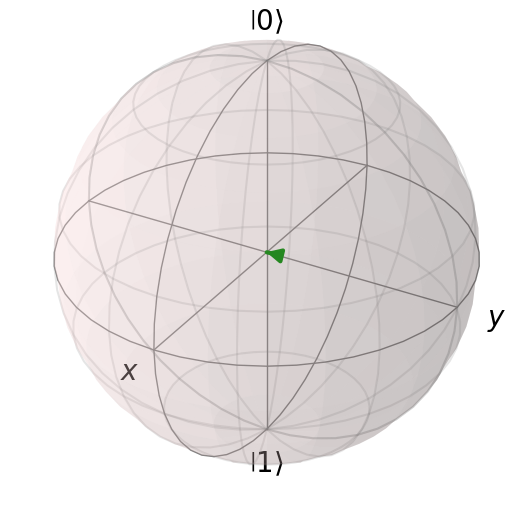

In [104]:
# 计算 Bloch 球坐标
bloch_vector = [2 * np.real(state[0] * np.conj(state[1])),
                2 * np.imag(state[0] * np.conj(state[1])),
                np.real(state[0] * np.conj(state[0]) - state[1] * np.conj(state[1]))]

print("Bloch 球坐标: ", bloch_vector)

# 绘制 Bloch 球
b = Bloch()
b.add_vectors(bloch_vector)  # 添加量子态的 Bloch 坐标
b.show()

In [105]:
# Some parts of this code are based on the Python script:
# https://github.com/pytorch/tutorials/blob/master/beginner_source/transfer_learning_tutorial.py
# License: BSD

import time
import os
import copy

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

import matplotlib.pyplot as plt
from qutip import Bloch

torch.manual_seed(42)
np.random.seed(42)

# Plotting
import matplotlib.pyplot as plt

# OpenMP: number of parallel threads.
os.environ["OMP_NUM_THREADS"] = "1"

In [106]:
n_qubits = 4                # Number of qubits
step = 0.0004               # Learning rate
batch_size = 64              # Number of samples for each training step
num_epochs = 3              # Number of training epochs
q_depth = 6                 # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1    # Learning rate reduction applied every 10 epochs.
q_delta = 0.01              # Initial spread of random quantum weights
start_time = time.time()    # Start of the computation timer

In [107]:
dev = qml.device("default.qubit", wires=n_qubits)

In [108]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [109]:
data_transforms = {
    "train": transforms.Compose(
        [
            # transforms.RandomResizedCrop(224),     # uncomment for data augmentation
            # transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # Normalize input channels using mean values and standard deviations of ImageNet.
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

data_dir = "/home/yangz2/code/data/data/hymenoptera_data/hymenoptera_data"
image_datasets = {
    x if x == "train" else "validation": datasets.ImageFolder(
        os.path.join(data_dir, x), data_transforms[x]
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "validation"]}
class_names = image_datasets["train"].classes

# Initialize dataloader
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # Inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

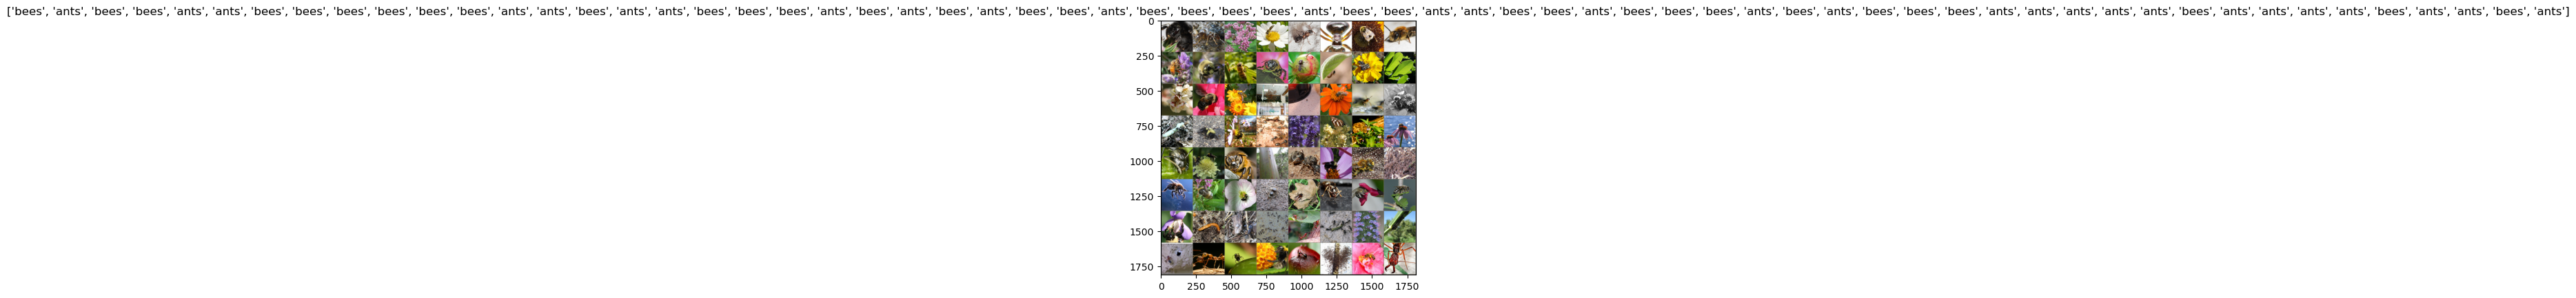

In [110]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["validation"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True)
    for x in ["train", "validation"]
}

In [111]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates.
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)


def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis.
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)


def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    # CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT
    for i in range(0, nqubits - 1, 2):  # Loop over even indices: i=0,2,...N-2
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [112]:
@qml.qnode(dev)
def quantum_net_state(q_input_features, q_weights_flat):
    """
    The variational quantum circuit.
    """

    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    H_layer(n_qubits)

    # Embed features in the quantum node
    RY_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangling_layer(n_qubits)
        RY_layer(q_weights[k])

    # 返回完整量子态
    return qml.state()

In [113]:
class DressedQuantumNet(nn.Module):
    
    def __init__(self):
        """
        Definition of the *dressed* layout.
        """
        super().__init__()
        self.pre_net = nn.Linear(512, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.post_net = nn.Linear(n_qubits, 2)
        
    def forward(self, input_features):
        """
        定义数据在混合量子神经网络中的流动方式。
        """
        pre_out = self.pre_net(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0

        all_states = []
        for elem in q_in:
            state = quantum_net_state(elem, self.q_params)

            # ✅ 确保 `state` 在 CPU 上，转换为 NumPy
            state = state.detach().cpu().numpy()

            all_states.append(state)
            
        q_out = torch.Tensor(0, n_qubits).to(device)
        for elem in q_in:
            state = quantum_net_state(elem, self.q_params)
            q_out_elem = torch.tensor(state[:n_qubits], dtype=torch.float32).unsqueeze(0)  # ✅ 只取前 n_qubits 维
            q_out = torch.cat((q_out, q_out_elem), dim=0)

        # 计算 Bloch 球坐标
        bloch_vectors = []
        for state in all_states:
            state_real = state.real
            state_imag = state.imag
            
            alpha, beta = state_real[0] + 1j * state_imag[0], state_real[1] + 1j * state_imag[1]

            x = 2 * np.real(alpha * np.conj(beta))
            y = 2 * np.imag(alpha * np.conj(beta))
            z = np.real(np.abs(alpha) ** 2 - np.abs(beta) ** 2)

            bloch_vectors.append([x, y, z])

        # ✅ 画 Bloch 球
        self.plot_bloch_sphere(bloch_vectors)

        return self.post_net(q_out)

    def plot_bloch_sphere(self, bloch_vectors):
        """
        使用 QuTiP 画出 Bloch 球，并标出所有 Bloch 向量。
        """
        b = Bloch()
        for vec in bloch_vectors:
            b.add_vectors(vec)
        b.show()


In [114]:
weights = torchvision.models.ResNet18_Weights.IMAGENET1K_V1
model_hybrid = torchvision.models.resnet18(weights=weights)

for param in model_hybrid.parameters():
    param.requires_grad = True


# Notice that model_hybrid.fc is the last layer of ResNet18
model_hybrid.fc = DressedQuantumNet().to(device)

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

# 检查 fc 是否包含参数
for name, param in model_hybrid.fc.named_parameters():
    print(name, param.shape, param.requires_grad)  # ✅ 确保参数存在

q_params torch.Size([24]) True
pre_net.weight torch.Size([4, 512]) True
pre_net.bias torch.Size([4]) True
post_net.weight torch.Size([2, 4]) True
post_net.bias torch.Size([2]) True


In [115]:
criterion = nn.CrossEntropyLoss()

In [116]:
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

In [117]:
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler
)

In [118]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 10000.0  # Large arbitrary number
    best_acc_train = 0.0
    best_loss_train = 10000.0  # Large arbitrary number
    print("Training started:")

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ["train", "validation"]:
            if phase == "train":
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            n_batches = dataset_sizes[phase] // batch_size
            it = 0
            for inputs, labels in dataloaders[phase]:
                since_batch = time.time()
                batch_size_ = len(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                # Track/compute gradient and make an optimization step only when training
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Print iteration results
                running_loss += loss.item() * batch_size_
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                print(
                    "Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}".format(
                        phase,
                        epoch + 1,
                        num_epochs,
                        it + 1,
                        n_batches + 1,
                        time.time() - since_batch,
                    ),
                    end="\r",
                    flush=True,
                )
                it += 1

            # Print epoch results
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print(
                "Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        ".format(
                    "train" if phase == "train" else "validation  ",
                    epoch + 1,
                    num_epochs,
                    epoch_loss,
                    epoch_acc,
                )
            )

            # Check if this is the best model wrt previous epochs
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == "validation" and epoch_loss < best_loss:
                best_loss = epoch_loss
            if phase == "train" and epoch_acc > best_acc_train:
                best_acc_train = epoch_acc
            if phase == "train" and epoch_loss < best_loss_train:
                best_loss_train = epoch_loss

            # Update learning rate
            if phase == "train":
                scheduler.step()

    # Print final results
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(
        "Training completed in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60)
    )
    print("Best test loss: {:.4f} | Best test accuracy: {:.4f}".format(best_loss, best_acc))
    return model

Training started:


/tmp/ipykernel_283789/2726370760.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem = torch.tensor(state[:n_qubits], dtype=torch.float32).unsqueeze(0)  # ✅ 只取前 n_qubits 维


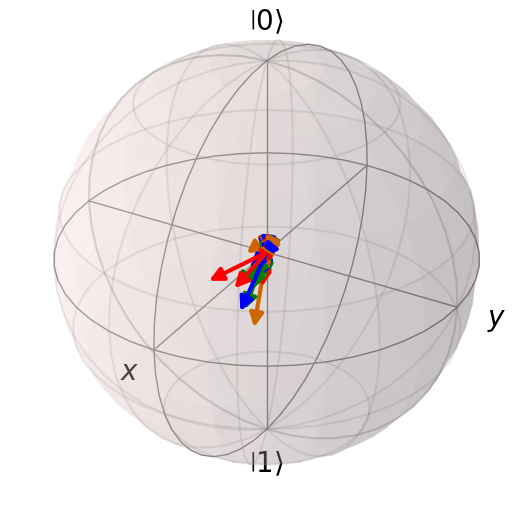

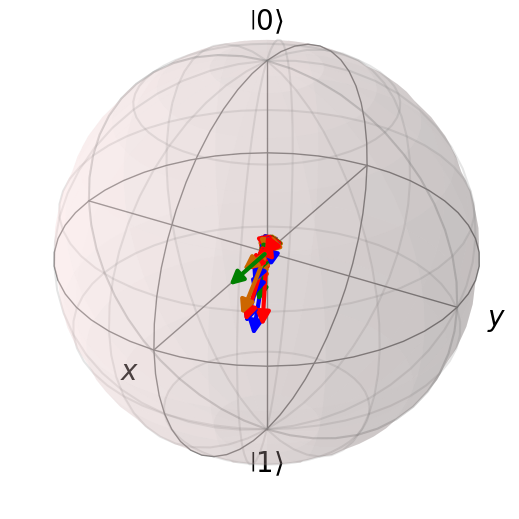

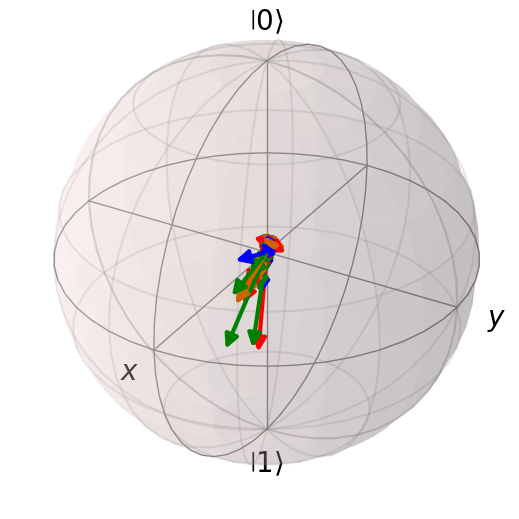

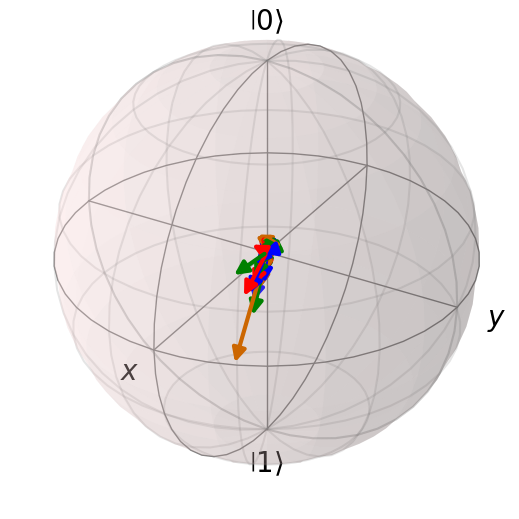

Phase: train Epoch: 1/3 Loss: 0.6977 Acc: 0.4344        


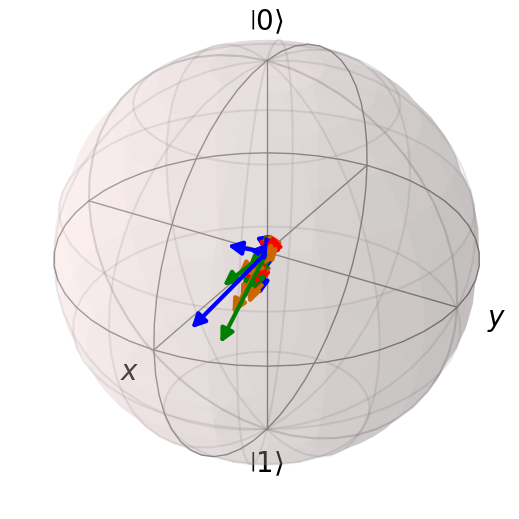

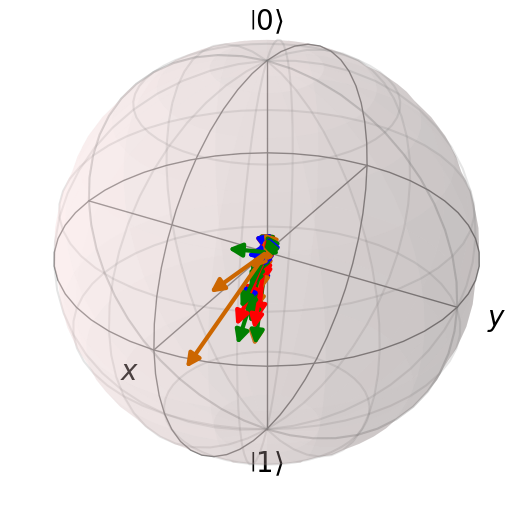

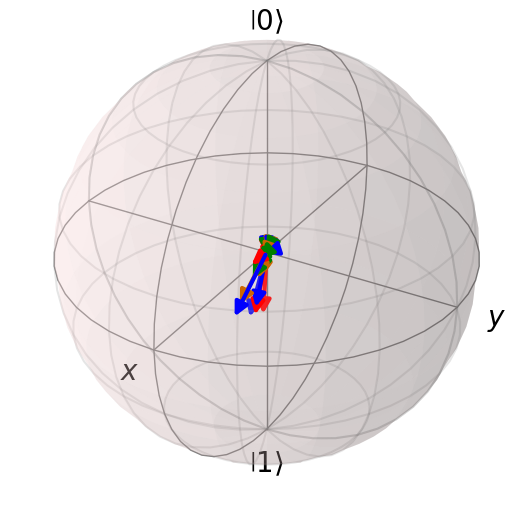

Phase: validation   Epoch: 1/3 Loss: 0.7114 Acc: 0.3007        


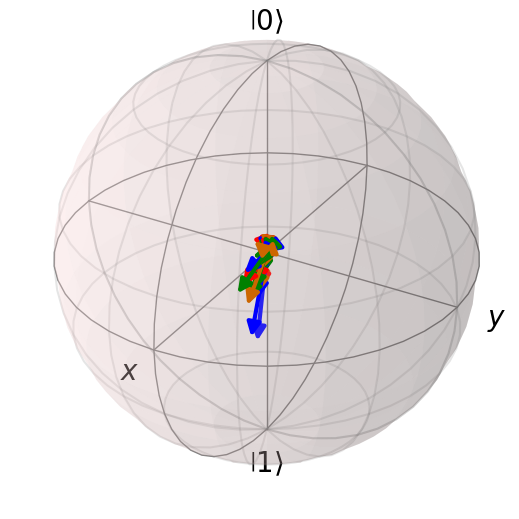

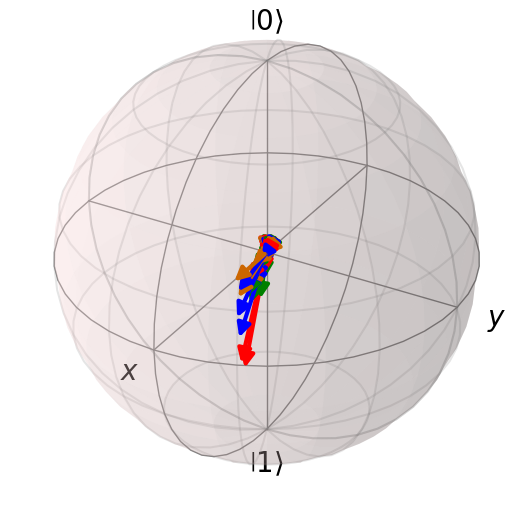

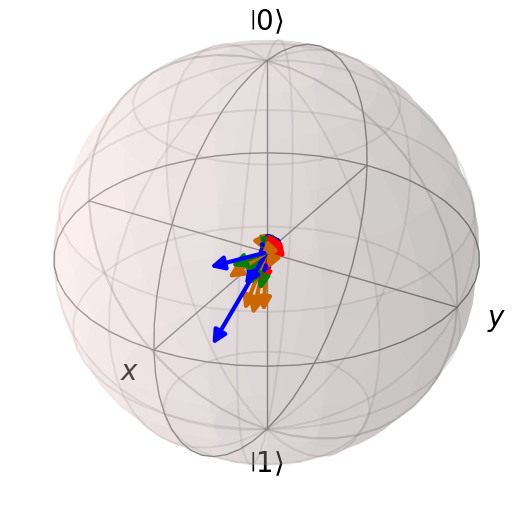

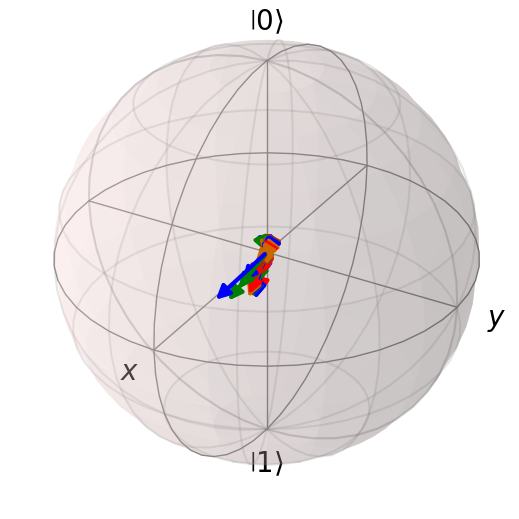

Phase: train Epoch: 2/3 Loss: 0.6983 Acc: 0.4385        


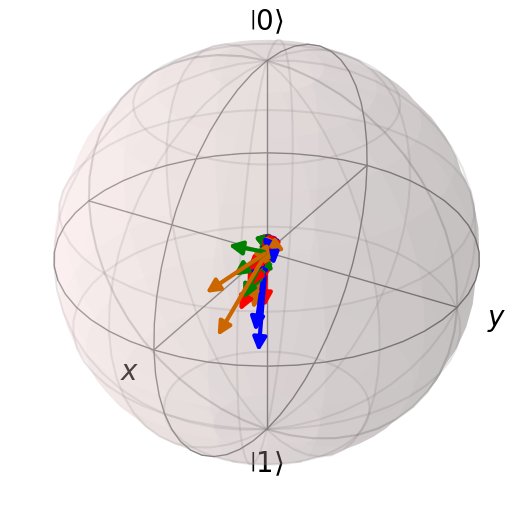

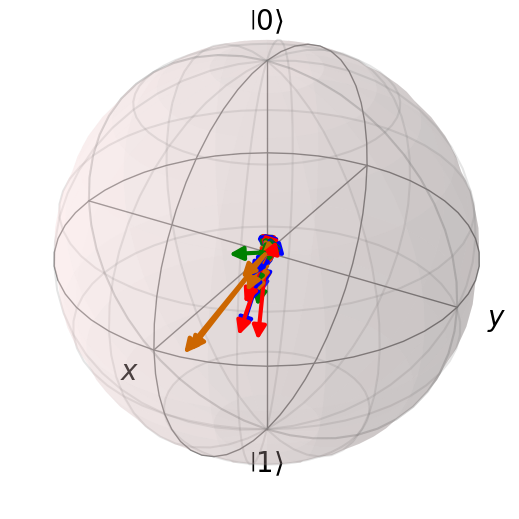

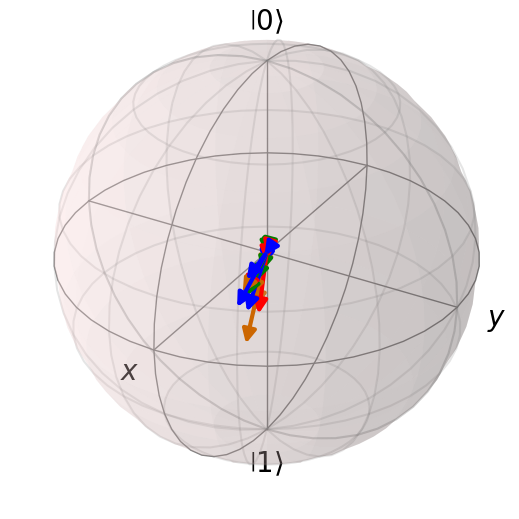

Phase: validation   Epoch: 2/3 Loss: 0.7098 Acc: 0.3007        


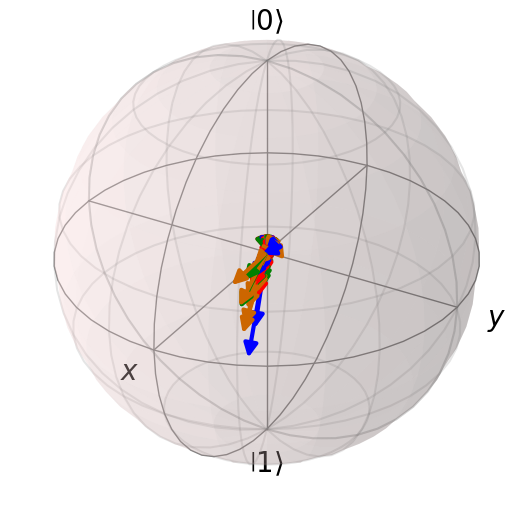

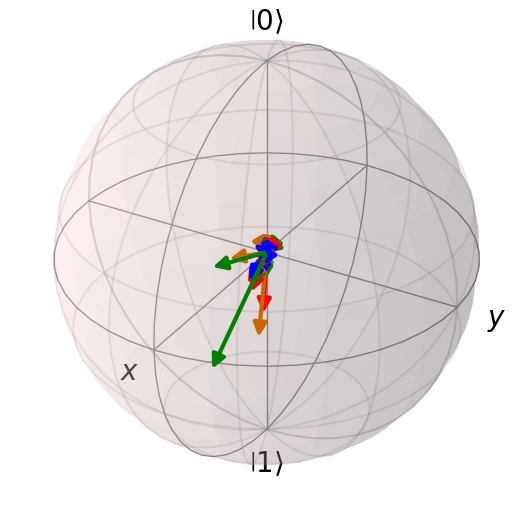

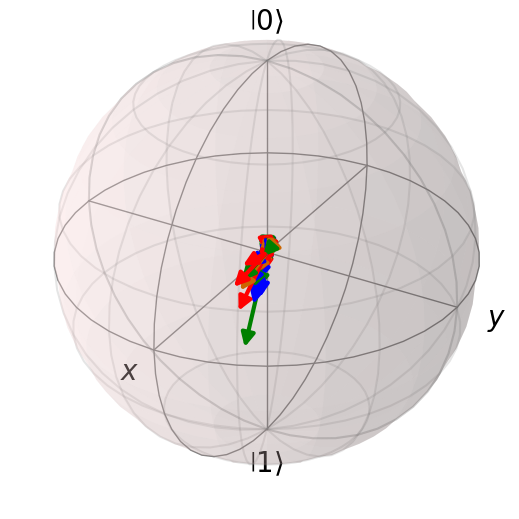

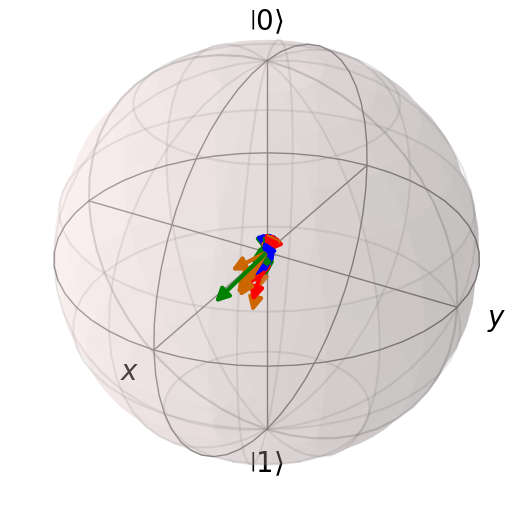

Phase: train Epoch: 3/3 Loss: 0.6983 Acc: 0.4385        


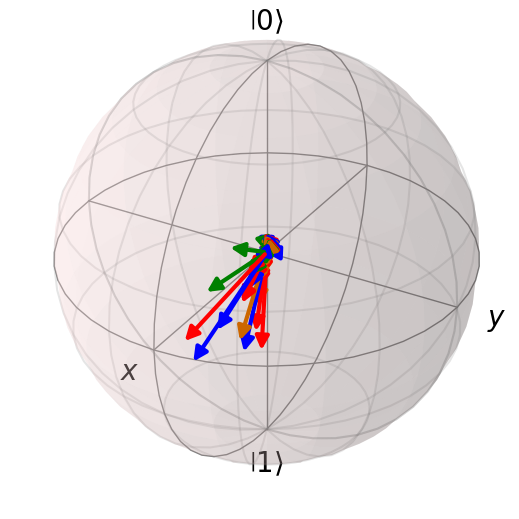

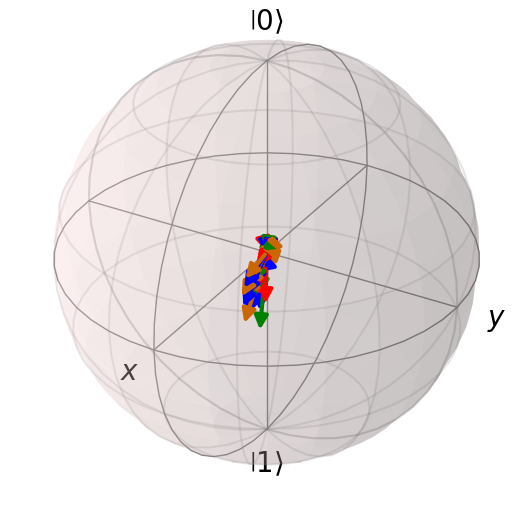

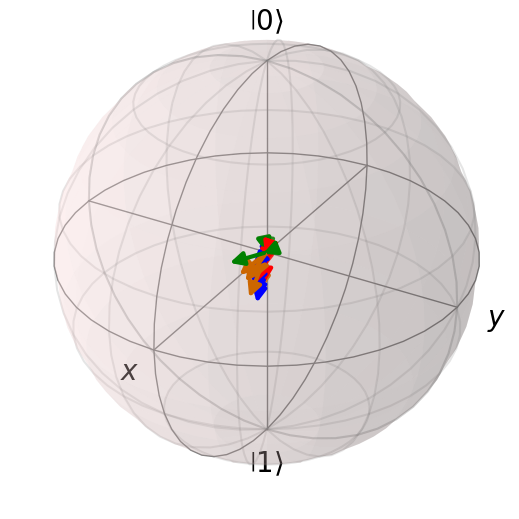

Phase: validation   Epoch: 3/3 Loss: 0.7082 Acc: 0.3203        
Training completed in 1m 39s
Best test loss: 0.7082 | Best test accuracy: 0.3203


In [119]:
model_hybrid = train_model(
    model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs
)

In [120]:
# list = [0.2372+0.j, 0.6289+0.j, 0.0223+0.j, 0.0605+0.j, 0.5429+0.j, 0.1976+0.j, 0.0462+0.j,
#         0.0167+0.j, 0.0139+0.j, 0.0017+0.j, 0.3221+0.j, 0.1271+0.j, 0.0032+0.j, 0.0143+0.j,
#         0.0965+0.j, 0.2796+0.j]
# tensor = torch.tensor(list, dtype=torch.complex64)
# # 计算 Bloch 球坐标
# bloch_vector = [2 * np.real(tensor[0] * np.conj(tensor[1])),
#                 2 * np.imag(tensor[0] * np.conj(tensor[1])),
#                 np.real(tensor[0] * np.conj(tensor[0]) - tensor[1] * np.conj(tensor[1]))]

# print("Bloch 球坐标: ", bloch_vector)

# # 绘制 Bloch 球
# b = Bloch()
# b.add_vectors(bloch_vector)  # 添加量子态的 Bloch 坐标
# b.show()

In [121]:
def visualize_model(model, num_images=6, fig_name="Predictions"):
    images_so_far = 0
    _fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for _i, (inputs, labels) in enumerate(dataloaders["validation"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title("[{}]".format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return

/tmp/ipykernel_283789/2726370760.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out_elem = torch.tensor(state[:n_qubits], dtype=torch.float32).unsqueeze(0)  # ✅ 只取前 n_qubits 维


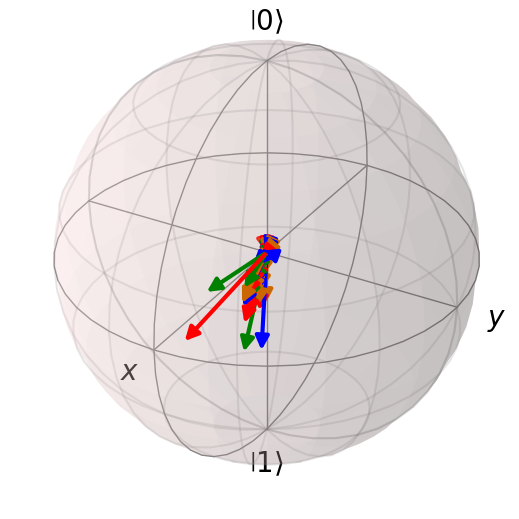

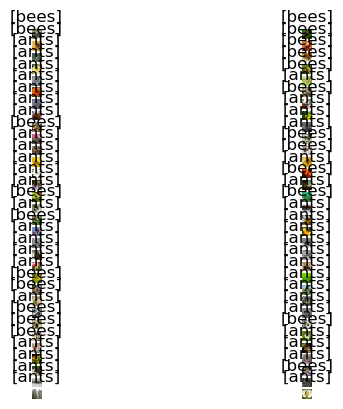

In [122]:
visualize_model(model_hybrid, num_images=batch_size)
plt.show()